# FXDECON

FXDECON is a tool commonly used to attenuate random noise in seismic data and images. It windows the data in time and traces, Fourier transforms in time, and then creates a prediction filter that attempts to use several traces to predict the value of the next trace. This prediction filter is then applied to the data it was trained on to estimate the predictable portion of the data, which should hopefully correspond to the signal and attenuate the random noise.

## References
* Treitel, Sven. "The complex Wiener filter." Geophysics 39.2 (1974): 169-173.
* Canales, Luis L. "Random noise reduction." SEG Technical Program Expanded Abstracts 1984. Society of Exploration Geophysicists, 1984. 525-527.
* Gulunay, Necati. "FXDECON and complex Wiener prediction filter." SEG Technical Program Expanded Abstracts 1986. Society of Exploration Geophysicists, 1986. 279-281.
* Galbraith, Mike. "Random noise attenuation by fx prediction: A tutorial." SEG Technical Program Expanded Abstracts 1991. Society of Exploration Geophysicists, 1991. 1428-1431.

## Derivation

Predict frequencies one step ahead using a linear prediction filter

\begin{equation}
y_{i+1} = f_0 x_i + f_1 x_{i-1} + ... + f_n x_{i-n},
\end{equation}
where $y$ is the predicted data, $f$ is a filter of length $n$, and $x$ is the input data.

The convolution can be expressed as a matrix multiplication:
\begin{equation}
\mathbf{y} = \mathbf{Xf},
\end{equation}
where $\mathbf{y}$ is of length $m - (n-1)$, $\mathbf{f}$ is of length $n$, and $\mathbf{X}$ is of shape $m - (n-1) \times n$.

X:
\begin{array}{cccc}
x_0 & x_1 & ... & x_{n-1} \\
x_1 & x_2 & ... & x_{n} \\
\vdots&&&\\
x_{m-n} & x_{m-n+1} & ... & x_{m-1}\\
\end{array}

The error with the true data is:
$e_i = d_i - y_i$

We seek to minimize the squared error:
\begin{align}
I = e^He &= (\mathbf{d} - \mathbf{Xf})^H(\mathbf{d} - \mathbf{Xf})\\
         &= \mathbf{d}^H\mathbf{d}-\mathbf{d}^H\mathbf{Xf}-\mathbf{f}^H\mathbf{X}^H\mathbf{d}+\mathbf{f}^H\mathbf{X}^H\mathbf{Xf}
         \end{align}
         
Let us define $\mathbf{R} = \mathbf{X}^H\mathbf{X}$, $\delta = \mathbf{d}^H\mathbf{d}$, and $\mathbf{g} = \mathbf{X}^H\mathbf{d}$, giving
\begin{equation}
I = \delta - \mathbf{g}^H\mathbf{f} - \mathbf{f}^H\mathbf{g}+\mathbf{f}^H\mathbf{R}\mathbf{f}.
\end{equation}

The error will be at a minimum when
\begin{equation}
\frac{dI}{d\mathbf{f}} = - \mathbf{g}^H +\mathbf{f}^H\mathbf{R} = 0.
\end{equation}

Thus,
\begin{equation}
\mathbf{f}^H\mathbf{R} = \mathbf{g}^H
\end{equation}
or
\begin{equation}
\mathbf{R}\mathbf{f} = \mathbf{g}
\end{equation}

We can split $\mathbf{R}$, $\mathbf{f}$, and $\mathbf{g}$ into real and imaginary components
\begin{equation}
\mathbf{R} = \mathbf{P} + i\mathbf{Q},
\end{equation}
where, since $\mathbf{R}$ is Hermitian ($\mathbf{R} = \mathbf{X}^T\mathbf{X} = \mathbf{R}^H$, real and symmetric), $\mathbf{Q} = -\mathbf{Q}^T$.

This gives
\begin{equation}
\mathbf{P}\mathbf{f}^{Re} - \mathbf{Q}\mathbf{f}^{Im} = \mathbf{g}^{Re}
\end{equation}
and
\begin{equation}
\mathbf{P}\mathbf{f}^{Im}+\mathbf{Q}\mathbf{f}^{Re} = \mathbf{g}^{Im}
\end{equation}

We can thus solve for $\mathbf{f}$ using the system

\begin{equation}
\begin{bmatrix}
\mathbf{P} & -\mathbf{Q} \\
\mathbf{Q} & \mathbf{P}
\end{bmatrix}
\begin{bmatrix}
\mathbf{f}^{Re} \\
\mathbf{f}^{Im}
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{g}^{Re} \\
\mathbf{g}^{Im}
\end{bmatrix}
\end{equation}

Once we have $\mathbf{f}$, we can use our earlier equation $\mathbf{y} = \mathbf{Xf}$ to obtain the denoised estimate.

## Example

I create a gather where the signal is predictable and the noise is random, and then use FXDECON to attenuate the noise.

In [1]:
import torch
from seispro import fxdecon

batch_size = 1
n_traces = 64
n_times = 128
signal = (torch.randn(batch_size, 1, n_times)
            + torch.arange(1, n_traces + 1).reshape(1, -1, 1)
            * torch.randn(batch_size, 1, n_times))
noise = torch.randn_like(signal) * signal.std().max()

noisy_data = signal + noise
denoised_data = fxdecon(noisy_data, time_window_len=32)

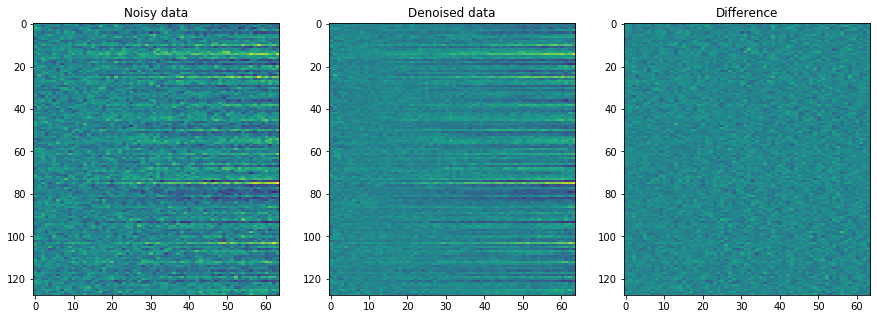

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

_, ax = plt.subplots(1,3,figsize=(15,5))
vmin, vmax = np.percentile(noisy_data.numpy(), [0, 100])
ax[0].imshow(noisy_data[0].numpy().T, aspect='auto', vmin=vmin, vmax=vmax)
ax[0].set_title('Noisy data')
ax[1].imshow(denoised_data[0].numpy().T, aspect='auto', vmin=vmin, vmax=vmax)
ax[1].set_title('Denoised data')
ax[2].imshow(noisy_data[0].numpy().T-denoised_data[0].numpy().T, aspect='auto', vmin=vmin, vmax=vmax)
ax[2].set_title('Difference');